In [1]:
INPUT_DIR = '/kaggle/input/anime-recommendation-database-2020'
!ls {INPUT_DIR}
DIR = '/kaggle/input/anime-model-genre'
!ls{DIR}

 anime.csv		   animelist.csv   rating_complete.csv
 anime_with_synopsis.csv  'html folder'    watching_status.csv
/usr/bin/sh: 1: ls/kaggle/input/anime-model-genre: not found


In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import csr_matrix
import tensorflow as tf
import subprocess
from IPython.display import FileLink, display
import math, re, os
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import time
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Reshape, Embedding, Dense, Flatten, Concatenate, Activation, Add, Lambda, BatchNormalization, Dropout, Dot, Multiply, PReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


In [5]:
# Reading the data from the csv files and storing them in pandas dataframes
dataset_df = pd.read_csv(INPUT_DIR + '/animelist.csv', low_memory=False)
dataset_df.head(4)

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0


In [6]:
# Filtering the dataset to only include users who have rated atleast 400 anime
total_ratings = dataset_df['user_id'].value_counts()
dataset_df = dataset_df[dataset_df['user_id'].isin(total_ratings[total_ratings >= 400].index)].copy()
len(dataset_df)

71418114

In [7]:

# Find the minimum rating in the dataset
min_rating = min(dataset_df['rating'])

# Find the maximum rating in the dataset
max_rating = max(dataset_df['rating'])

# Apply the min-max normalization formula to each rating in the dataset
# The lambda function subtracts the minimum rating from each rating and divides it by the range (max rating - min rating)
dataset_df['rating'] = dataset_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

# Calculate the average rating in the dataset
avg_rating = np.mean(dataset_df['rating'])

# Print the average rating
print('Avg', avg_rating)

Avg 0.4047793589172634


In [8]:
# Check for duplicates in the dataset
duplicates = dataset_df.duplicated()

# If there are duplicates
if duplicates.sum() > 0:
    # Print the number of duplicates
    print('> {} duplicates'.format(duplicates.sum()))
    # Remove the duplicates from the dataset
    dataset_df = dataset_df[~duplicates]

# Print the number of duplicates after removing them
print('> {} duplicates'.format(dataset_df.duplicated().sum()))

> 1 duplicates
> 0 duplicates


## **Data Preprocessing**

In [10]:
# Create a list of unique user IDs in the dataset
user_ids = dataset_df["user_id"].unique().tolist()
# Create a mapping of unique user IDs to encoded values
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
# Create a mapping of encoded user values to their corresponding user IDs
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
# Map the user IDs in the dataset to their encoded values
dataset_df["user"] = dataset_df["user_id"].map(user2user_encoded)
# Determine the total number of unique users in the dataset
total_users = len(user2user_encoded)

# Create a list of unique anime IDs in the dataset
anime_ids = dataset_df["anime_id"].unique().tolist()
# Create a mapping of unique anime IDs to encoded values
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
# Create a mapping of encoded anime values to their corresponding anime IDs
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
# Map the anime IDs in the dataset to their encoded values
dataset_df["anime"] = dataset_df["anime_id"].map(anime2anime_encoded)
# Determine the total number of unique animes in the dataset
total_animes = len(anime2anime_encoded)

print("Num of users: {}, Num of animes: {}".format(total_users, total_animes))
print("Min rating: {}, Max rating: {}".format(min(dataset_df['rating']), max(dataset_df['rating'])))


Num of users: 91641, Num of animes: 17560
Min rating: 0.0, Max rating: 1.0


In [11]:
# Shuffle the dataset to ensure that the model does not overfit to the order of the data
dataset_df = dataset_df.sample(frac=1, random_state=73)

# Split the dataset into X and y 
X = dataset_df[['user', 'anime']].values
y = dataset_df["rating"]

In [12]:
# Split the dataset into training and testing sets with a test set size of 10,000
test_set_size = 10000
train_indices = dataset_df.shape[0] - test_set_size 

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 71408113
> Test set ratings: 10000


In [ ]:
# Using Genre in Embedding
GENRE = False

if GENRE:
    # Load anime.csv to extract genres
    anime_df = pd.read_csv(INPUT_DIR + '/anime.csv', usecols=['MAL_ID','Name', 'Genres'])

    # Split genres into lists
    anime_df['Genres'] = anime_df['Genres'].apply(lambda x: x.split(', '))

    # Encode genres as a multi-hot encoded matrix
    mlb = MultiLabelBinarizer()
    genre_matrix = mlb.fit_transform(anime_df['Genres'])

    # Create a DataFrame with encoded genres
    genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)
    genre_df['anime_id'] = anime_df['MAL_ID']

    # Map anime_id to encoded genres
    genre_map = genre_df.set_index('anime_id').to_dict('index')

    total_genres = genre_matrix.shape[1]
    # Create a dictionary mapping genres to their index in the multi-hot encoded matrix
    genre2index = {genre: idx for idx, genre in enumerate(mlb.classes_)}

    # Helper functions
    def get_genre_vector(anime_id):
        """
        Returns the genre vector for a given anime ID.
        """
        if anime_id in genre_map:
            return list(genre_map[anime_id].values())
        else:
            return [1 if genre == 'Unknown' else 0 for genre in mlb.classes_]
        
    def get_weighted_genre_vector(MAL_ID, max_weight=1.0, decay_rate=0.5):
        """
        Generates a weighted genre vector based on the order of genres.
        The first genre has the highest weight, and the weight decreases
        exponentially for subsequent genres.
        """
        genres = anime_df.loc[anime_df['MAL_ID'] == MAL_ID, 'Genres'].values[0] if MAL_ID in anime_df['MAL_ID'].values else ['Unknown']
        genre_vector = np.zeros(total_genres)
        for i, genre in enumerate(genres):
            if genre in genre2index:
                weight = max_weight * (decay_rate ** i)
                genre_vector[genre2index[genre]] = weight
        return genre_vector
    
    def get_wgenre_vector(anime_id):
        """
        Returns the weighted genre vector for a given anime ID.
        """
        if anime_id in genre_weighted_map:
            return list(genre_weighted_map[anime_id])
        else:
            return [1 if genre == 'Unknown' else 0 for genre in mlb.classes_]

    # Create a dictionary of genre vectors for each anime
    genre_weighted_map = {}

    # Iterate through each anime ID and generate a weighted genre vector
    for MAL_ID in anime_df['MAL_ID']:
        genre_weighted_map[MAL_ID] = get_weighted_genre_vector(MAL_ID)


In [14]:
if GENRE:
    # Apply the function to generate genre vectors for the training and test sets
    X_train_genres = np.array([get_wgenre_vector(anime_id) for anime_id in X_train[:, 1]])
    X_test_genres = np.array([get_wgenre_vector(anime_id) for anime_id in X_test[:, 1]])
    
    # Create a list of input arrays for the model
    X_train_array = [X_train[:, 0], X_train[:, 1], X_train_genres]
    X_test_array = [X_test[:, 0], X_test[:, 1], X_test_genres]
else:
    # Create a list of input arrays for the model
    X_train_array = [X_train[:, 0], X_train[:, 1]]
    X_test_array = [X_test[:, 0], X_test[:, 1]]


print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 71408113
> Test set ratings: 10000


## **Model Building**

In [ ]:

AUTO = tf.data.experimental.AUTOTUNE

# Detect TPU, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    tpu_strategy = tf.distribute.get_strategy() 

In [20]:
print("REPLICAS: ", tpu_strategy.num_replicas_in_sync)

REPLICAS:  8


In [21]:
TPU_INIT = True

print(tf.__version__)

2.16.1


In [ ]:
# Define the model architecture without using genres in the embedding layer
def RecommenderNet():
    embedding_size = 128
    
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                        input_dim = total_users, 
                        output_dim = embedding_size)(user)
    
    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',
                        input_dim = total_animes, 
                        output_dim = embedding_size)(anime)
    
    #x = Concatenate()([user_embedding, anime_embedding])
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    x = Flatten()(x)
        
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model


In [20]:
# Define the model architecture using genres without weights in the embedding layer
def RecommenderNetWithGenres():
    # Model configuration parameters
    embedding_size = 128
    genre_embedding_size = 128
    
    # User embedding
    user = Input(name='user', shape=[1])
    user_embedding = Embedding(name='user_embedding',
                               input_dim=total_users,
                               output_dim=embedding_size)(user)
    user_embedding = Flatten()(user_embedding)
    
    # Anime embedding
    anime = Input(name='anime', shape=[1])
    anime_embedding = Embedding(name='anime_embedding',
                                input_dim=total_animes,
                                output_dim=embedding_size)(anime)
    anime_embedding = Flatten()(anime_embedding)
    
    # Genre input
    genre = Input(name='genre', shape=[total_genres])
    genre_embedding = Dense(genre_embedding_size, activation='relu')(genre)
    
    # Normalize genre embeddings
    genre_embedding = BatchNormalization()(genre_embedding)
    
    # Combining embeddings
    x = Concatenate()([user_embedding, anime_embedding, genre_embedding])
    
    # Apply dense layers
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    
    # Output layer
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    output = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, anime, genre], outputs=output)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='adam')
    
    return model


In [21]:
# Define the model architecture using genres with weights in the embedding layer
# The weights are assigned based on the order of genres in the list

def RecommenderNetWithWeightedGenres():
    # Model configuration parameters
    embedding_size = 512 
    genre_embedding_size = 256 

    # User embedding
    user = Input(name='user', shape=[1])
    user_embedding = Embedding(name='user_embedding',
                                input_dim=total_users,
                                output_dim=embedding_size,
                                embeddings_regularizer=l2(1e-6))(user)
    user_embedding = Flatten()(user_embedding)

    # Anime embedding
    anime = Input(name='anime', shape=[1])
    anime_embedding = Embedding(name='anime_embedding',
                                input_dim=total_animes,
                                output_dim=embedding_size,
                                embeddings_regularizer=l2(1e-6))(anime)
    anime_embedding = Flatten()(anime_embedding)

    # Genre input
    genre = Input(name='genre', shape=[total_genres])
    genre_embedding = Dense(genre_embedding_size, activation='relu')(genre)
    genre_embedding = BatchNormalization()(genre_embedding)

    # Combining embeddings
    x = Concatenate()([user_embedding, anime_embedding, genre_embedding])

    # Apply dense layers with regularization and different activation functions
    x = Dense(1024, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = PReLU()(x)
    x = Dropout(0.5)(x)

    x = Dense(512, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = PReLU()(x)
    x = Dropout(0.4)(x)

    x = Dense(256, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = PReLU()(x)
    x = Dropout(0.3)(x)

    x = Dense(128, kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = PReLU()(x)
    x = Dropout(0.2)(x)

    # Output layer
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    output = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime, genre], outputs=output)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer=Adam(learning_rate=1e-4, clipnorm=1.0))

    return model


In [23]:

# Create the model using the appropriate architecture based on the genre flag and TPU initialization
if TPU_INIT:
    if GENRE:
        with tpu_strategy.scope():
            model = RecommenderNetWithWeightedGenres()
    else:    
        with tpu_strategy.scope():
            model = RecommenderNet()
else:
    if GENRE:
        model = RecommenderNetWithWeightedGenres()
    else:    
        model = RecommenderNet()

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │ 11,730,048 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,247,680 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,977,734 (53.32 MB)

 Trainable params: 13,977,732 (53.32 MB)

 Non-trainable params: 2 (8.00 B)

In [24]:
# Define the learning rate schedule for the model
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

# Adjust the learning rate based on the number of replicas in the TPU strategy
if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

# Define the learning rate schedule
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    """ Learning rate schedule function """
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

In [25]:
# Create a learning rate scheduler
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# Define the model checkpoint and early stopping callbacks
checkpoint_filepath = './checkpoint.weights.h5'
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss', 
                                mode='min', restore_best_weights=True)

# Define the callbacks for the model
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping,   
]

In [26]:
# Train the model using the training and testing sets and the defined callbacks and learning rate schedule
with tpu_strategy.scope():
    history = model.fit(
        x=X_train_array,
        y=y_train,
        batch_size=batch_size,
        epochs=30,
        verbose=1,
        validation_data=(X_test_array, y_test),
        callbacks=my_callbacks
    )

model.load_weights(checkpoint_filepath)

Epoch 1/30


2024-08-19 18:52:53.151494: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1724093578.369781   13286 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ee39c8e53400b1cf:0:0), session_name()


  8/893 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.8037 - mae: 0.3845 - mse: 0.1999  

I0000 00:00:1724093579.569956   13286 tpu_compile_op_common.cc:245] Compilation of ee39c8e53400b1cf:0:0 with session name  took 1.20010824s and succeeded
I0000 00:00:1724093579.575101   13286 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ee39c8e53400b1cf:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2231776312669388948", property.function_library_fingerprint = 15145182478996057494, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "10000,;10000,;10000,1,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1724093579.575144   13286 tpu_compilation_cache_interface.cc:541] After adding entry for k

890/893 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8031 - mae: 0.3846 - mse: 0.1998

I0000 00:00:1724093592.046731   13239 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(b28ad886ae5dcde:0:0), session_name()


893/893 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8031 - mae: 0.3846 - mse: 0.1998

I0000 00:00:1724093593.078371   13239 tpu_compile_op_common.cc:245] Compilation of b28ad886ae5dcde:0:0 with session name  took 1.031596316s and succeeded
I0000 00:00:1724093593.082849   13239 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(b28ad886ae5dcde:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2231776312669388948", property.function_library_fingerprint = 15145182478996057494, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "6015,;6015,;6015,1,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1724093593.082876   13239 tpu_compilation_cache_interface.cc:541] After adding entry for key b

893/893 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - loss: 0.8031 - mae: 0.3846 - mse: 0.1998 - val_loss: 0.7977 - val_mae: 0.3885 - val_mse: 0.2004 - learning_rate: 1.0000e-05
Epoch 2/30
893/893 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.7948 - mae: 0.3830 - mse: 0.1969 - val_loss: 0.7757 - val_mae: 0.3842 - val_mse: 0.1925 - learning_rate: 8.8000e-05
Epoch 3/30
893/893 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.7598 - mae: 0.3733 - mse: 0.1835 - val_loss: 0.7050 - val_mae: 0.3558 - val_mse: 0.1632 - learning_rate: 1.6600e-04
Epoch 4/30
893/893 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 0.6482 - mae: 0.3214 - mse: 0.1356 - val_loss: 0.5958 - val_mae: 0.2943 - val_mse: 0.1146 - learning_rate: 2.4400e-04
Epoch 5/30
893/893 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.5773 - mae: 0.2792 - mse: 0.1045 - val_loss: 0.5669 - val_mae: 0.2733 - val_mse: 0.1025 - learning_rate: 3.2200e-04
Epoch 6/30
893/893 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.5502 - mae: 0.2570 - mse: 0.0937 - val_loss: 0.

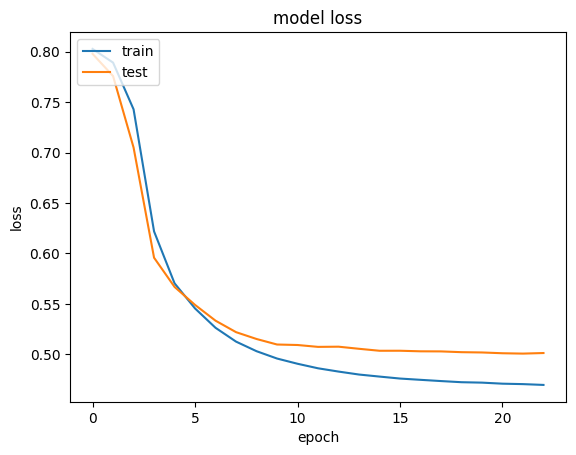

In [27]:

# Plot the loss and validation loss for the model
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [30]:
# Save the model for future use
with tpu_strategy.scope():
    model.save('anime_model_w/o_g.h5')

In [31]:
# Display the link to download the model
FileLink(r'./anime_model_w/o_g.h5')

/kaggle/working/anime_model_w/o_g.h5

In [62]:
# Load the saved model from the file just after training (with genres)
model = tf.keras.models.load_model('/kaggle/input/anime-model-genre/anime_model_wrt_genre.h5')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre (InputLayer)  │ (None, 44)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │ 11,730,048 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,247,680 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      2,880 │ genre[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 128)       │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 128)       │          0 │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 320)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     82,176 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,096,071 (53.77 MB)

 Trainable params: 14,095,939 (53.77 MB)

 Non-trainable params: 130 (520.00 B)

 Optimizer params: 2 (12.00 B)

## **Extracting weights from model**

In [ ]:
# Function to extract and normalize weights
def extract_weights(name, model):
    '''
    Extracts and normalizes the weights of the specified layer in the model.
    '''
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)
if GENRE:
    genre_weights = extract_weights('dense_2', model)


### **anime meta data**

In [32]:
# Variables to save for future use

variables_to_save = {
    'mlb': mlb,
    'anime_encoded2anime': anime_encoded2anime,
    'anime_weights': anime_weights,
    'genre_map': genre_map,
    'anime2anime_encoded': anime2anime_encoded
}

# Save the variables to a pickle file
with open('variables.pkl', 'wb') as f:
    pickle.dump(variables_to_save, f)


In [34]:
df = pd.read_csv(INPUT_DIR + '/anime.csv')
# Load anime.csv to extract genres
anime_df = df

# Split genres into lists
anime_df['Genres'] = anime_df['Genres'].apply(lambda x: x.split(', '))

#Encode genres as a multi-hot encoded matrix
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(anime_df['Genres'])

# Create a DataFrame with encoded genres
genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_)
genre_df['anime_id'] = anime_df['MAL_ID']
#df = df.replace("Unknown", np.nan)

# Fixing Names
def getAnimeName(anime_id):
    """Returns the name of the anime given the anime ID."""
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if pd.isna(name):
            name = df[df.anime_id == anime_id].Name.values[0]
    except Exception as e:
        print(f'Error: {e}')
    return name

# Get the DataFrame row for the given anime
def getAnimeFrame(anime):
    """Returns the DataFrame row for the given anime."""
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]
    
# Split genres into lists
df['Genres'] = df['Genres'].apply(lambda x: x.split(', '))
df['anime_id'] = df['MAL_ID']
df["eng_version"] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))

In [35]:
# Sort the DataFrame by score in descending order
df.sort_values(by=['Score'], inplace=True, ascending=False, kind='quicksort', na_position='last')
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

# Encode genres as a multi-hot encoded matrix
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(df['Genres'])

total_genres = genre_matrix.shape[1]
genre2index = {genre: idx for idx, genre in enumerate(mlb.classes_)}
def get_genre_vector(anime_id):
    """ Returns the genre vector for a given anime ID. """
    if anime_id in genre_map:
        return list(genre_map[anime_id].values())
    else:
        return [1 if genre == 'Unknown' else 0 for genre in mlb.classes_]
    
def get_weighted_genre_vector(MAL_ID, max_weight=1.0, decay_rate=0.5):
    """
    Generates a weighted genre vector based on the order of genres.
    The first genre has the highest weight, and the weight decreases
    exponentially for subsequent genres.
    """
    genres = df.loc[df['anime_id'] == MAL_ID, 'Genres'].values[0] if MAL_ID in df['anime_id'].values else ['Unknown']
    genre_vector = np.zeros(total_genres)
    for i, genre in enumerate(genres):
        if genre in genre2index:
            weight = max_weight * (decay_rate ** i)
            genre_vector[genre2index[genre]] = weight
    return genre_vector
genre_weighted_map = {}
# Map anime_id to encoded genres
genre_map = genre_df.set_index('anime_id').to_dict('index')

for MAL_ID in df['anime_id']:
    genre_weighted_map[MAL_ID] = get_weighted_genre_vector(MAL_ID)
    
def get_wgenre_vector(anime_id):
    """ Returns the weighted genre vector for a given anime ID. """
    if anime_id in genre_weighted_map:
        return list(genre_weighted_map[anime_id])
    else:
        return [1 if genre == 'Unknown' else 0 for genre in mlb.classes_]

### **synopsis data**

In [49]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]
synopsis_df = pd.read_csv('/kaggle/input/anime-recommendation-database-2020/anime_with_synopsis.csv', usecols=cols)

def getSynopsis(anime):
    """ Returns the synopsis for a given anime"""
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]


# Recommendation without Genre Weights

In [44]:
#pd.reset_option('all')
pd.set_option("max_colwidth", None)

def recommend_anime(name, n=10, return_dist=False, neg=False):
        """
        Recommends n anime similar to the given anime without genres taken into account.
        """
        # Get the anime ID for the given anime name
        index = getAnimeFrame(name).anime_id.values[0]
        # Get the encoded index for the anime
        encoded_index = anime2anime_encoded.get(index)        
        # Calculate the cosine similarity between the anime and all other anime
        dists = np.dot(anime_weights, anime_weights[encoded_index])
        sorted_dists = np.argsort(dists)
        # Get the n most similar anime
        n = n + 1            
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        
        SimilarityArr = []
        # Iterate through the most similar anime
        for close in closest:
            # Get the decoded anime ID
            decoded_id = anime_encoded2anime.get(close)
            # Get the synopsis for the anime
            synopsis = getSynopsis(decoded_id)
            # Get the frame for the anime
            anime_frame = getAnimeFrame(decoded_id)
            
            # Get the name of the anime
            anime_name = anime_frame.eng_version.values[0]
            # Get the genre of the anime
            genre = anime_frame.Genres.values[0]
            # Get the similarity score
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name,
                                  "similarity": similarity,"genre": genre,
                                  'Synopsis': synopsis})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)


# Recommendation with Genre Weights (Different Model)

In [72]:
def recommend_anime(name, n=10):
    """
    Recommends n anime similar to the given anime wit genhres taken into account.
    """

    # Get the index of the anime in the model
    start_time = time.time()
    
    anime_id = getAnimeFrame(name).anime_id.values[0]
    anime_idx = anime2anime_encoded[anime_id]

    # Get the weighted genre vector for the target anime
    target_wgenre_vector = get_weighted_genre_vector(anime_id)
    normalized_target_wgenre_vector = target_wgenre_vector / np.linalg.norm(target_wgenre_vector)

    # Precompute the reshaped genre weights
    reshaped_genre_weights = genre_weights.reshape(-1, 1)

    # Calculate cosine similarity with all other animes
    similarities = []
    for idx, anime_vector in enumerate(anime_weights):
        # Get the corresponding genre vector and normalize it
        current_wgenre_vector = get_weighted_genre_vector(anime_encoded2anime[idx])
        normalized_current_wgenre_vector = current_wgenre_vector / np.linalg.norm(current_wgenre_vector)
        
        # Combine anime and genre weights into a single vector
        combined_vector = np.concatenate((anime_vector, (normalized_current_wgenre_vector * reshaped_genre_weights).flatten()))
        combined_target_vector = np.concatenate((anime_weights[anime_idx], (normalized_target_wgenre_vector * reshaped_genre_weights).flatten()))
        
        # Compute cosine similarity
        similarity = cosine_similarity([combined_vector], [combined_target_vector])

        similarities.append((anime_encoded2anime[idx], similarity))

    # Sort by similarity score in descending order
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Filter recommendations based on the type of the input anime
    input_anime_type = df.loc[df['anime_id'] == anime_id, 'Type'].values[0]
    if input_anime_type == 'TV':
        filtered_recommendations = [sim for sim in similarities if df.loc[df['anime_id'] == sim[0], 'Type'].values[0] == 'TV']
    elif input_anime_type == 'Movie':
        filtered_recommendations = [sim for sim in similarities if df.loc[df['anime_id'] == sim[0], 'Type'].values[0] in ['TV', 'Movie']]
    else:
        filtered_recommendations = similarities

    # Initialize an empty list to store the similarity information
    SimilarityArr = []

    # Iterate over the filtered recommendations
    n = min(n+1, len(filtered_recommendations))
    for anime_id, similarity in filtered_recommendations[1:n]:
        anime_frame = getAnimeFrame(anime_id)
        anime_name = anime_frame.eng_version.values[0]
        genre = anime_frame.Genres.values[0]
        synopsis = getSynopsis(anime_id)
        SimilarityArr.append({
            "ID": anime_id,
            "Name": anime_name,
            "Similarity": similarity,
            "Genre": genre,
            "Synopsis": synopsis
        })

    # Create a DataFrame and sort by similarity in descending order
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="Similarity", ascending=False)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    print(f"Time taken: {int(minutes)} minutes and {seconds:.2f} seconds")
    
    return Frame


# Test the function Without Genre

In [50]:
recommend_anime(name="One Piece", n=5)

,name,similarity,genre,Synopsis
4,Bleach,0.783755,"[Action, Adventure, Comedy, Super Power, Supernatural, Shounen]","Ichigo Kurosaki is an ordinary high schooler—until his family is attacked by a Hollow, a corrupt spirit that seeks to devour human souls. It is then that he meets a Soul Reaper named Rukia Kuchiki, who gets injured while protecting Ichigo's family from the assailant. To save his family, Ichigo accepts Rukia's offer of taking her powers and becomes a Soul Reaper as a result. However, as Rukia is unable to regain her powers, Ichigo is given the daunting task of hunting down the Hollows that plague their town. However, he is not alone in his fight, as he is later joined by his friends—classmates Orihime Inoue, Yasutora Sado, and Uryuu Ishida—who each have their own unique abilities. As Ichigo and his comrades get used to their new duties and support each other on and off the battlefield, the young Soul Reaper soon learns that the Hollows are not the only real threat to the human world."
3,Naruto:Shippuden,0.755232,"[Action, Adventure, Comedy, Super Power, Martial Arts, Shounen]","It has been two and a half years since Naruto Uzumaki left Konohagakure, the Hidden Leaf Village, for intense training following events which fueled his desire to be stronger. Now Akatsuki, the mysterious organization of elite rogue ninja, is closing in on their grand plan which may threaten the safety of the entire shinobi world. Although Naruto is older and sinister events loom on the horizon, he has changed little in personality—still rambunctious and childish—though he is now far more confident and possesses an even greater determination to protect his friends and home. Come whatever may, Naruto will carry on with the fight for what is important to him, even at the expense of his own body, in the continuation of the saga about the boy who wishes to become Hokage."
2,Naruto,0.749690,"[Action, Adventure, Comedy, Super Power, Martial Arts, Shounen]","oments prior to Naruto Uzumaki's birth, a huge demon known as the Kyuubi, the Nine-Tailed Fox, attacked Konohagakure, the Hidden Leaf Village, and wreaked havoc. In order to put an end to the Kyuubi's rampage, the leader of the village, the Fourth Hokage, sacrificed his life and sealed the monstrous beast inside the newborn Naruto. Now, Naruto is a hyperactive and knuckle-headed ninja still living in Konohagakure. Shunned because of the Kyuubi inside him, Naruto struggles to find his place in the village, while his burning desire to become the Hokage of Konohagakure leads him not only to some great new friends, but also some deadly foes."
1,Fairy Tail,0.694811,"[Action, Adventure, Comedy, Magic, Fantasy, Shounen]","In the mystical land of Fiore, magic exists as an essential part of everyday life. Countless magic guilds lie at the core of all magical activity, and serve as venues for like-minded mages to band together and take on job requests. Among them, Fairy Tail stands out from the rest as a place of strength, spirit, and family. Lucy Heartfilia is a young mage searching for celestial gate keys, and her dream is to become a full-fledged wizard by joining this famous guild. In her search, she runs into Natsu Dragneel and his partner Happy, who are on a quest to find Natsu's foster father, the dragon Igneel. Upon being tricked by a man, Lucy falls under an abduction attempt, only to be saved by Natsu. To her shock, he reveals that he is a member of Fairy Tail and invites her to join them. There, Lucy meets the guild's strange members, such as the ice wizard Gray Fullbuster and magic swordswoman Erza Scarlet. Together as a family, they battle the forces of evil, help those in need, and gain new friends, all the while enjoying the never-ending adventure that is Fairy Tail."
0,Hunter x Hunter,0.680887,"[Action, Adventure, Fantasy, Shounen, Super Power]","Hunter x Hunter is set in a world where Hunters exist to perform all manner of dangerous tasks like capturing criminals and bravely searching 

In [52]:
recommend_anime('Your Lie in April', n=5)

,name,similarity,genre,Synopsis
4,Your Name.,0.793032,"[Romance, Supernatural, School, Drama]","suha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture. One day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another. Kimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
3,A Silent Voice,0.780994,"[Drama, School, Shounen]","s a wild youth, elementary school student Shouya Ishida sought to beat boredom in the cruelest ways. When the deaf Shouko Nishimiya transfers into his class, Shouya and the rest of his class thoughtlessly bully her for fun. However, when her mother notifies the school, he is singled out and blamed for everything done to her. With Shouko transferring out of the school, Shouya is left at the mercy of his classmates. He is heartlessly ostracized all throughout elementary and middle school, while teachers turn a blind eye. Now in his third year of high school, Shouya is still plagued by his wrongdoings as a young boy. Sincerely regretting his past actions, he sets out on a journey of redemption: to meet Shouko once more and make amends. Koe no Katachi tells the heartwarming tale of Shouya's reunion with Shouko and his honest attempts to redeem himself, all while being continually haunted by the shadows of his past."
2,ERASED,0.775839,"[Mystery, Psychological, Supernatural, Seinen]","hen tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save many lives. However, when he is wrongfully accused of murdering someone close to him, Satoru is sent back to the past once again, but this time to 1988, 18 years in the past. Soon, he realizes that the murder may be connected to the abduction and killing of one of his classmates, the solitary and mysterious Kayo Hinazuki, that took place when he was a child. This is his chance to make things right. Boku dake ga Inai Machi follows Satoru in his mission to uncover what truly transpired 18 years ago and prevent the death of his classmate while protecting those he cares about in the present."
1,anohana:The Flower We Saw That Day,0.766216,"[Slice of Life, Supernatural, Drama]","Jinta Yadomi is peacefully living as a recluse, spending his days away from school and playing video games at home instead. One hot summer day, his childhood friend, Meiko ""Menma"" Honma, appears and pesters him to grant a forgotten wish. He pays her no mind, which annoys her, but he doesn't really care. After all, Menma already died years ago. At first, Jinta thinks that he is merely hallucinating due to the summer heat, but he is later on convinced that what he sees truly is the ghost of Menma. Jinta and his group of childhood friends grew apart after her untimely death, but they are drawn together once more as they try to lay Menma's spirit to rest. Re-living their pain and guilt, will they be able to find the strength to help not only Menma move on—but themselves as well?"
0,Noragami:Stray God,0.711719,"[Action, Adventure, Comedy, Supernatural, Shounen]","In times of need, if you look in the right place, you just may see a strange telephone number scrawled in red. If you call this number, you will hear a young man introduce himself as the Yato God. Yato is a minor deity and a s

In [53]:
recommend_anime('Terror in Resonance', n=5)

,name,similarity,genre,Synopsis
4,Death Parade,0.780403,"[Game, Mystery, Psychological, Drama, Thriller]","fter death, there is no heaven or hell, only a bar that stands between reincarnation and oblivion. There the attendant will, one after another, challenge pairs of the recently deceased to a random game in which their fate of either ascending into reincarnation or falling into the void will be wagered. Whether it's bowling, darts, air hockey, or anything in between, each person's true nature will be revealed in a ghastly parade of death and memories, dancing to the whims of the bar's master. Welcome to Quindecim, where Decim, arbiter of the afterlife, awaits! Death Parade expands upon the original one-shot intended to train young animators. It follows yet more people receiving judgment—until a strange, black-haired guest causes Decim to begin questioning his own rulings."
3,Parasyte -the maxim-,0.745708,"[Action, Sci-Fi, Horror, Psychological, Drama, Seinen]","ll of a sudden, they arrived: parasitic aliens that descended upon Earth and quickly infiltrated humanity by burrowing into the brains of vulnerable targets. These insatiable beings acquire full control of their host and are able to morph into a variety of forms in order to feed on unsuspecting prey. Sixteen-year-old high school student Shinichi Izumi falls victim to one of these parasites, but it fails to take over his brain, ending up in his right hand instead. Unable to relocate, the parasite, now named Migi, has no choice but to rely on Shinichi in order to stay alive. Thus, the pair is forced into an uneasy coexistence and must defend themselves from hostile parasites that hope to eradicate this new threat to their species."
2,Psycho-Pass,0.742360,"[Action, Sci-Fi, Police, Psychological]","Justice, and the enforcement of it, has changed. In the 22nd century, Japan enforces the Sibyl System, an objective means of determining the threat level of each citizen by examining their mental state for signs of criminal intent, known as their Psycho-Pass. Inspectors uphold the law by subjugating, often with lethal force, anyone harboring the slightest ill-will; alongside them are Enforcers, jaded Inspectors that have become latent criminals, granted relative freedom in exchange for carrying out the Inspectors' dirty work. Into this world steps Akane Tsunemori, a young woman with an honest desire to uphold justice. However, as she works alongside veteran Enforcer Shinya Kougami, she soon learns that the Sibyl System's judgments are not as perfect as her fellow Inspectors assume. With everything she has known turned on its head, Akane wrestles with the question of what justice truly is, and whether it can be upheld through the use of a system that may already be corrupt."
1,ERASED,0.712522,"[Mystery, Psychological, Supernatural, Seinen]","hen tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save many lives. However, when he is wrongfully accused of murdering someone close to him, Satoru is sent back to the past once again, but this time to 1988, 18 years in the past. Soon, he realizes that the murder may be connected to the abduction and killing of one of his classmates, the solitary and mysterious Kayo Hinazuki, that took place when he was a child. This is his chance to make things right. Boku dake ga Inai Machi follows Satoru in his mission to uncover what truly transpired 18 years ago and prevent the death of his classmate while protecting those he cares about in the present."
0,Noragami:Stray God,0.674467,"[Action, Adventure, Comedy, Supernatural, Shounen]","In times of need, if you look in the right place, you just may see a strange telephone number scrawled in red. If you call this number, you will hear a young man introduce himself as the Yato God. Yato is a minor deity and 

# Test the function With Genre

In [73]:
recommend_anime(name="One Piece", n=5)

Time taken: 1 minutes and 15.56 seconds


,ID,Name,Similarity,Genre,Synopsis
0,30694,Dragon Ball Super,[[0.9872989858691285]],"[Action, Adventure, Comedy, Super Power, Martial Arts, Fantasy, Shounen]","Seven years after the events of Dragon Ball Z , Earth is at peace, and its people live free from any dangers lurking in the universe. However, this peace is short-lived; a sleeping evil awakens in the dark reaches of the galaxy: Beerus, the ruthless God of Destruction. Disturbed by a prophecy that he will be defeated by a ""Super Saiyan God,"" Beerus and his angelic attendant Whis start searching the universe for this mysterious being. Before long, they reach Earth where they encounter Gokuu Son, one of the planet's mightiest warriors, and his similarly powerful friends."
1,269,Bleach,[[0.9866078205394893]],"[Action, Adventure, Comedy, Super Power, Supernatural, Shounen]","Ichigo Kurosaki is an ordinary high schooler—until his family is attacked by a Hollow, a corrupt spirit that seeks to devour human souls. It is then that he meets a Soul Reaper named Rukia Kuchiki, who gets injured while protecting Ichigo's family from the assailant. To save his family, Ichigo accepts Rukia's offer of taking her powers and becomes a Soul Reaper as a result. However, as Rukia is unable to regain her powers, Ichigo is given the daunting task of hunting down the Hollows that plague their town. However, he is not alone in his fight, as he is later joined by his friends—classmates Orihime Inoue, Yasutora Sado, and Uryuu Ishida—who each have their own unique abilities. As Ichigo and his comrades get used to their new duties and support each other on and off the battlefield, the young Soul Reaper soon learns that the Hollows are not the only real threat to the human world."
2,20,Naruto,[[0.9851681245806119]],"[Action, Adventure, Comedy, Super Power, Martial Arts, Shounen]","oments prior to Naruto Uzumaki's birth, a huge demon known as the Kyuubi, the Nine-Tailed Fox, attacked Konohagakure, the Hidden Leaf Village, and wreaked havoc. In order to put an end to the Kyuubi's rampage, the leader of the village, the Fourth Hokage, sacrificed his life and sealed the monstrous beast inside the newborn Naruto. Now, Naruto is a hyperactive and knuckle-headed ninja still living in Konohagakure. Shunned because of the Kyuubi inside him, Naruto struggles to find his place in the village, while his burning desire to become the Hokage of Konohagakure leads him not only to some great new friends, but also some deadly foes."
3,1735,Naruto:Shippuden,[[0.9847006910057859]],"[Action, Adventure, Comedy, Super Power, Martial Arts, Shounen]","It has been two and a half years since Naruto Uzumaki left Konohagakure, the Hidden Leaf Village, for intense training following events which fueled his desire to be stronger. Now Akatsuki, the mysterious organization of elite rogue ninja, is closing in on their grand plan which may threaten the safety of the entire shinobi world. Although Naruto is older and sinister events loom on the horizon, he has changed little in personality—still rambunctious and childish—though he is now far more confident and possesses an even greater determination to protect his friends and home. Come whatever may, Naruto will carry on with the fight for what is important to him, even at the expense of his own body, in the continuation of the saga about the boy who wishes to become Hokage."
4,22777,Dragon Ball Z Kai:The Final Chapters,[[0.9826013217843533]],"[Action, Adventure, Comedy, Super Power, Martial Arts, Fantasy, Shounen]",mastered version of the Majin Buu saga that adheres more to the manga's story.


In [74]:
recommend_anime('Your Lie in April', n=5)

Time taken: 1 minutes and 53.55 seconds


,ID,Name,Similarity,Genre,Synopsis
0,38889,Kono Oto Tomare!:Sounds of Life Season 2,[[0.9826088229529523]],"[Drama, Music, Romance, School, Shounen]","The Tokise High School Koto Club has courageously pushed through their fractured and unsynchronized performance at the Kanto Region Traditional Japanese Music Festival. Clubmembers Chika Kudou, Satowa Houzuki, Takezou Kurata, Hiro Kurusu, Kouta Mizuhara, Saneyasu Adachi, and Michitaka Sakai are devastated to learn the negative results of their performance, leaving them crushed. Nonetheless, the group recognizes their potential and enthusiastically agree to collectively sharpen their skills, improve their flaws, and develop higher caliber playing to succeed in the upcoming national qualifiers in winter. With the help of their now willing club advisor Suzuka Takinami, the group's goal gradually becomes achievable as they begin to grasp the foundations of good music and refine their koto-playing abilities, with the suggestion of performing more often to gain what they lack most—experience. However, as their journey to nationals is underway, the koto club members face challenges that obstruct their focus and progress. Not only does the threat of other powerhouse schools and musicians remain, but the high school issues of budding romance and soon-to-be-graduating seniors also begin to push the limits of the determined group of teenagers and the future of the koto club."
1,18245,White Album 2,[[0.9766277327994382]],"[Drama, Music, Romance, Slice of Life]","Haruki Kitahara's light music club is on the verge of disbanding. At this rate, the third year's dream of performing at the school festival would never be realized. However, as his exhausted fingers drift through the chords of ""White Album,"" the first song he would ever play, an angelic voice and mysterious piano begin harmonizing with his lonely guitar. It is a momentous performance that marks the beginning of everything for Haruki. White Album 2 orchestrates Haruki's final semester with complex romance and exhilarating music, as the curtains of the stage he so desired begin to open..."
2,38080,Kono Oto Tomare!:Sounds of Life,[[0.9734566485760215]],"[Drama, Music, Romance, School, Shounen]","Gen Kudou, a koto maker, believes that his delinquent grandson Chika would never understand the profoundness of the traditional musical instrument. In an attempt to make up for his naivety and understand the words of his late grandfather, Chika tries to join the Tokise High School Koto Club. Even though the club is in dire need of members, new club president Takezou Kurata is unwilling to easily accept Chika's application due to his bad reputation. Nonetheless, after seeing Chika's seriousness and enthusiasm, Takezou allows the problem child to join, along with koto prodigy Satowa Houzuki and three of Chika's energetic friends. Kono Oto Tomare! follows the merry band of musicians as they aspire to play at the national competition."
3,39533,Unknown,[[0.9696012189122246]],"[Drama, Music, Romance, Shounen Ai, Slice of Life]","Tightly clutching his Gibson guitar, Mafuyu Satou steps out of his dark apartment to begin another day of his high school life. While taking a nap in a quiet spot on the gymnasium staircase, he has a chance encounter with fellow student Ritsuka Uenoyama, who berates him for letting his guitar's strings rust and break. Noticing Uenoyama's knowledge of the instrument, Satou pleads for him to fix it and to teach him how to play. Uenoyama eventually agrees and invites him to sit in on a jam session with his two band mates: bassist Haruki Nakayama and drummer Akihiko Kaji. Satou's voice is strikingly beautiful, filling Uenoyama with the determination to make Satou the lead singer of the band. Though reticent at first, Satou takes the offer after an emotional meeting with an old friend. With the support of his new friends, Satou must not only learn how to play guitar, but also come to terms with the mysterious circumstances that 

39533 : Anime is called Given


1021 : Anime is called Kaikan Phrase

In [75]:
recommend_anime('Terror in Resonance', n=5)

Time taken: 1 minutes and 53.32 seconds


,ID,Name,Similarity,Genre,Synopsis
0,37525,Unknown,[[0.9798541531050232]],"[Mystery, Psychological, Thriller]","In the newly formed Shiniki district of Tokyo, Zen Seizaki is a diligent public prosecutor at the Tokyo District Public Prosecutors Office. Assigned to a case involving false advertisement, Zen—along with his assistant officer, Atsuhiko Fumio—investigate Japan Supiri, a pharmaceutical company that had provided fabricated clinical research on the company's new drug. While investigating the file of Shin Inaba, an anesthesiologist connected to the crime, the case takes a dark turn when Zen finds a page stained with a mixture of blood, hair and skin, along with the letter ""F"" scribbled all across the sheet. As he investigates further, the case goes beyond Zen's imagination and becomes vastly complex, challenging his sense of justice and his knowledge of the truth. Digging deeper into the investigation, Zen begins to uncover a concealed plot behind the ongoing mayoral election and ties to many people of interest involved in the election and those closer than he thinks. The case grows more severe and propels Zen into an unforeseen hurricane of corruption and deceit behind the election, the establishment of the Shiniki district, and the mysterious woman associated with it all."
1,1889,When They Cry:Kai,[[0.9552554181186385]],"[Mystery, Psychological, Supernatural, Thriller]","In the small village of Hinamizawa, Rika Furude and her friends live together in relative harmony. Beneath this mask of peace, however, lies a hidden darkness, one that Rika understands all too well. In this eternal summer, she has been witness to unspeakable horrors. Every time the clock resets, Rika must try to find the villain behind these senseless deaths before tragedy strikes again. However, trying to decipher a mystery when only half the clues are present proves time and again to be disastrous, and each time she believes that things will change, she inevitably fails. As the annual festival approaches, Rika begins her descent from hope to despair in her struggle to break the chains of fate entangling them all."
2,4879,Unknown,[[0.9446377462215452]],"[Mystery, Psychological, Supernatural, Thriller, Seinen]",The story follows a series of bizarre murders of schoolgirls who have been dismembered and stuffed into boxes. The private investigator hired by a missing daughter's mother joins forces with an antique book seller and others to unravel the murder spree. (Source: ANN)
3,31043,ERASED,[[0.9394767007533348]],"[Mystery, Psychological, Supernatural, Seinen]","hen tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save many lives. However, when he is wrongfully accused of murdering someone close to him, Satoru is sent back to the past once again, but this time to 1988, 18 years in the past. Soon, he realizes that the murder may be connected to the abduction and killing of one of his classmates, the solitary and mysterious Kayo Hinazuki, that took place when he was a child. This is his chance to make things right. Boku dake ga Inai Machi follows Satoru in his mission to uncover what truly transpired 18 years ago and prevent the death of his classmate while protecting those he cares about in the present."
4,3713,Hell Girl:Three Vessels,[[0.926354290669918]],"[Mystery, Psychological, Supernatural]","Following the events of Jigoku Shoujo Futakomori , Ai Enma, the Hell Girl, has disappeared. Her former companions decide to lead normal lives, until their absent mistress returns to them with a new companion, and in a way that none of them anticipated. Yuzuki Mikage is a normal schoolgirl who soon comes to understand the Hell Girl on an intimate level. During a dream-like trance in the bathtub, Ai kisses Yuzuki and possesses her. So when Yuzuki's friend decides to t

37525 : Anime is Called Babylon

4879 : Anime is Called Box of Goblins